In [40]:
# imports
#bigqueryhelper
from google.cloud import bigquery
import pandas as pd
import numpy as np
import plotly
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [41]:
# API key verification for Google Cloud
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/davidhofhuizen/Projects/EDA_Bitcoin-ledger/rugged-ether-350608-2a8031aeb288.json"
client = bigquery.Client()

Functions

In [42]:
def run_query(query):
    query_job = client.query(query)

    iterator = query_job.result(timeout=120000)
    rows = list(iterator)

    # Transform the rows into a nice pandas dataframe
    result = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
    
    return result

In [43]:
query =  '''
WITH double_entry_book AS (
    -- debits
    SELECT
     array_to_string(inputs.addresses, ",") as address
    , inputs.type
    , -inputs.value as value
    , block_timestamp
    FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
 
    UNION ALL
 
    -- credits
    SELECT
     array_to_string(outputs.addresses, ",") as address
    , outputs.type
    , outputs.value as value
    , block_timestamp
    FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
)
,double_entry_book_by_date as (
    select 
        date(block_timestamp) as date, 
        address, 
        sum(value / POWER(10,0)) as value
    from double_entry_book
    group by address, date
)
,daily_balances_with_gaps as (
    select 
        address, 
        date,
        sum(value) over (partition by address order by date) as balance,
        lead(date, 1, current_date()) over (partition by address order by date) as next_date
        from double_entry_book_by_date
)
,calendar as (
    select date from unnest(generate_date_array('2009-01-12', current_date())) as date
)
,daily_balances as (
    select address, calendar.date, balance
    from daily_balances_with_gaps
    join calendar on daily_balances_with_gaps.date <= calendar.date and calendar.date < daily_balances_with_gaps.next_date
)
,supply as (
    select
        date,
        sum(balance) as daily_supply
    from daily_balances
    group by date
)
,ranked_daily_balances as (
    select 
        daily_balances.date,
        balance,
        row_number() over (partition by daily_balances.date order by balance desc) as rank
    from daily_balances
    join supply on daily_balances.date = supply.date
    where safe_divide(balance, daily_supply) >= 0.0001
    ORDER BY safe_divide(balance, daily_supply) DESC
)

select 
    date, 
    -- (1 − 2B) https://en.wikipedia.org/wiki/Gini_coefficient
    1 - 2 * sum((balance * (rank - 1) + balance / 2)) / count(*) / sum(balance) as gini
from ranked_daily_balances
group by date
order by date asc
'''

In [44]:
test = '1 - 2 * sum((balance * (rank - 1) + balance / 2)) / count(*) / sum(balance) as gini,'

In [45]:
query1 = '''
WITH double_entry_book AS (
   -- debits
   SELECT array_to_string(inputs.addresses, ",") as address, inputs.type, -inputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
   UNION ALL
   -- credits
   SELECT array_to_string(outputs.addresses, ",") as address, outputs.type, outputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
)
SELECT address, type, sum(value) as balance
FROM double_entry_book
GROUP BY address, type
'''

In [46]:
gini = run_query(query1)
gini

Forbidden: 403 Response too large to return. Consider specifying a destination table in your job configuration. For more details, see https://cloud.google.com/bigquery/troubleshooting-errors

Location: US
Job ID: 1311df26-9bb9-4c75-9395-6854bb35bb2d


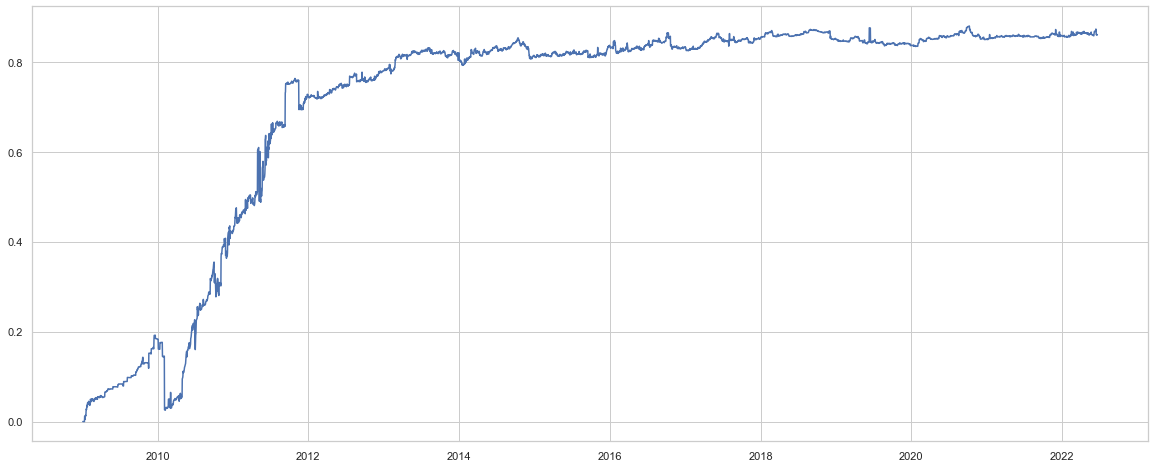

In [ ]:
plt.figure(figsize = [20,8])
plt.plot(gini['date'], gini['gini'])
plt.show()